In [21]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Establish plotting order
drug_list = [
    'ISONIAZID',
    'RIFAMPICIN',
    'ETHAMBUTOL',
    'PYRAZINAMIDE',
    'STREPTOMYCIN', 
    'AMIKACIN',
    'CAPREOMYCIN',
    'KANAMYCIN',
    'CIPROFLOXACIN',
    'OFLOXACIN',
    'MOXIFLOXACIN', 
    'LEVOFLOXACIN',
    'ETHIONAMIDE', 
]

model_order = [
    "Reg+L2",
    "WDNN",
    "MD-CNN",
    "SD-CNN"
]

## Selecting an MD-CNN architecture

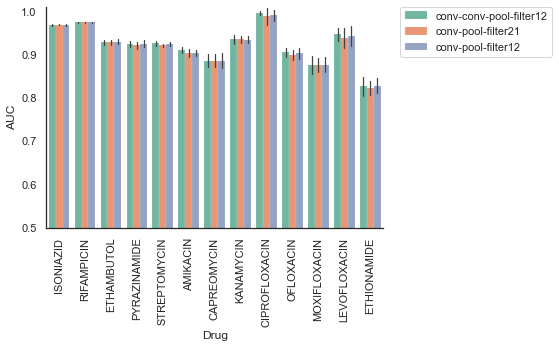

In [25]:
### Comparing the three  MD-CNN models

# Establish a color scheme
colors=[
    "#00b3ca",
    "#9dc6d8",
    "#e38690",
]

sns.set(rc={"lines.linewidth": 0.7})
sns.set_style("white")
sns.set_palette("Set2")

## Read in the cross validation AUC for each of the three models
example_21 = pd.read_csv('results_20210201_filter21_epochs200/20210201_filter21_epochs200_auc.csv')
example_21['model'] = 'conv-pool-filter21'
example_12 = pd.read_csv('results_20210203_filter12_epoch200/results_20210203_filter12_epoch200_auc.csv')
example_12['model'] = 'conv-pool-filter12'
example_ccp = pd.read_csv('results_20210201_ccp_filter12_epoch150/results_20210201_ccp_filter12_epoch150_auc.csv')
example_ccp['model'] = 'conv-conv-pool-filter12'

# Concatenate
x = pd.concat([
    example_12, 
    example_21,
    example_ccp,
])

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(drug_list, range(len(drug_list))))
modelSorterIndex = dict(zip(model_order, range(len(model_order))))

# Generate a rank column that will be used to sort
# the dataframe numerically
x['rank'] = x['Drug'].map(sorterIndex)
x = x.sort_values(["rank"])

# Plot
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.barplot(data=x, x="Drug", y="AUC", hue="model", ax=ax, linewidth=0.1, ci="sd")
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0.5,1.01])
plt.xticks(rotation = 90)
plt.tight_layout()
#plt.show()
plt.savefig("MD-CNN_architecture_AUC_comparison_zoomed.pdf")

## Comparing models on training set cross validation

In [ ]:
## Collate the Regression + L2 results
xval_l2_data = pd.DataFrame()
for file in glob.glob("20210611_L2_regression/*/XVal_accuracy.csv"):
    _d = pd.read_csv(file, index_col=0)
    drug = file.split("/")[1]
    _d["Drug"] = drug
    xval_l2_data = pd.concat([xval_l2_data, _d])
xval_l2_data.to_csv("20210611_L2_regression/combined_XVal_accuracy.csv")
xval_l2_data.drug.unique()

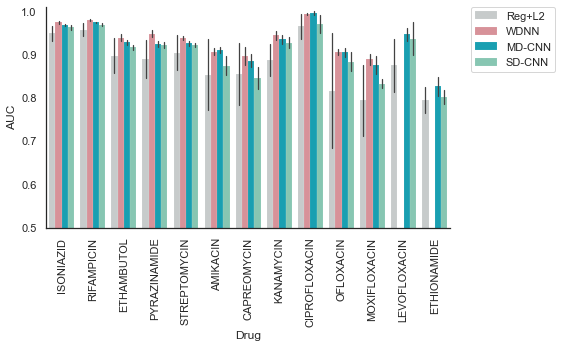

In [47]:
## Comparing the MD-CNN, SD-CNN, L@, and WDNN performance on cross-validation set
colors=[
        "#c6cccc","#e38690",
     "#00b3ca","#7dd0b6"
]
sns.set_palette(sns.color_palette(colors))
sns.set(rc={"lines.linewidth": 0.7})
sns.set_style("white")

# Read in the Xval AUC for each model
example_ccp = pd.read_csv('results_20210201_ccp_filter12_epoch150/results_20210201_ccp_filter12_epoch150_auc.csv')
example_ccp['model'] = 'MD-CNN'
example_l2 = pd.read_csv('20210611_L2_regression/combined_XVal_accuracy.csv')
example_l2["model"] = "Reg+L2"
singletasks = pd.read_csv("../singletasks/singletask_model_auc.csv")
singletasks["model"] = "SD-CNN"
wdnn = pd.read_csv("results_cv_wdnn_091719/wdnn_cv_070720_threshold_round1.csv")
wdnn['model'] = 'WDNN'

# Concatenate into single df
x = pd.concat([
    example_l2, wdnn, 
    example_ccp, singletasks
])

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(drug_list, range(len(drug_list))))
modelSorterIndex = dict(zip(model_order, range(len(model_order))))

# Generate a rank column that will be used to sort
# the dataframe numerically
x['rank'] = x['Drug'].map(sorterIndex)
x['model_rank']= x['model'].map(modelSorterIndex)
x = x.sort_values(["rank", "model_rank"])

sns.set_palette(sns.color_palette(colors))

# Plot
fig = plt.figure(figsize=(8,5))
ax = fig.gca()
sns.barplot(data=x, x="Drug", y="AUC", hue="model", ax=ax, linewidth=0.1, ci="sd")
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0.5,1.01])
plt.xticks(rotation = 90)
plt.tight_layout()
#plt.show()
plt.savefig("allmodel_AUC_comparison_zoomed.pdf")

In [49]:
# Mean AUC for models

first_line_mtcnn = x.query("model=='MD-CNN' ")
print("Mean AUC, MD-CNN", first_line_mtcnn.AUC.mean())

first_line_wdnn = x.query("model=='WDNN'")
print("Mean AUC, WDNN", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='Reg+L2' ")
print("Mean AUC, Reg+L2", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='SD-CNN'")
print("Mean AUC, SD-CNN", first_line_wdnn.AUC.mean())

Mean first AUC, MT-CNN nan
Mean first AUC, WDBB 0.9372341599852709
Mean first AUC, Reg+L2 0.8794205067562131
Mean first AUC, STCNN nan


In [50]:
# Mean AUC for first-line drugs

first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_mtcnn = x.query("model=='MD-CNN' and Drug in @first_line")
print("Mean first line AUC, MD-CNN", first_line_mtcnn.AUC.mean())

first_line_wdnn = x.query("model=='WDNN' and Drug in @first_line")
print("Mean first line AUC, WDNN", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='Reg+L2' and Drug in @first_line")
print("Mean first line AUC, Reg+L2", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='SD-CNN' and Drug in @first_line")
print("Mean first line AUC, SD-CNN", first_line_wdnn.AUC.mean())

Mean first line AUC, MT-CNN nan
Mean first line AUC, WDBB 0.9599008957405555
Mean first line AUC, Reg+L2 0.9227566743404922
Mean first line AUC, STCNN nan


In [51]:
## Mean AUC for second line drugs
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_mtcnn = x.query("model=='MD-CNN' and not Drug in @first_line")
print("Mean second line AUC, MD-CNN", first_line_mtcnn.AUC.mean())

first_line_wdnn = x.query("model=='WDNN' and not Drug in @first_line")
print("Mean second line AUC, WDNN", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='Reg+L2' and not Drug in @first_line")
print("Mean second line AUC, Reg+L2", first_line_wdnn.AUC.mean())

first_line_wdnn = x.query("model=='SD-CNN' and not Drug in @first_line")
print("Mean second line AUC, STCNN", first_line_wdnn.AUC.mean())

Mean second line AUC, MT-CNN nan
Mean second line AUC, WDBB 0.9242817395536798
Mean second line AUC, Reg+L2 0.8601599878298667
Mean second line AUC, STCNN nan


## Comparing CNN models on Test set

In [30]:
## SD-CNN test set performances

## This snippet reads the files from o2 and combines - no need to rerun
# path = "/Users/agreen/Beam_O2_mount/annachang/singletask_focus_v2/*tf1_model/*test_set_drug_auc.csv"
# sd_files = glob.glob(path)
# d = pd.DataFrame()
# for file in sd_files:
#     _d = pd.read_csv(file, index_col=0)
#     d = pd.concat([d, _d])
# d.to_csv("singletask_test_set_auc.csv")

singletask_test = pd.read_csv("singletask_test_set_auc.csv", index_col=0)
singletask_test['set'] = "SD-CNN_test"
singletasks = pd.read_csv("../singletasks/singletask_model_auc.csv")
singletasks['set'] = "SD-CNN_train"
singletasks= pd.concat([singletasks, singletask_test])

# MD-CNN test set performances

# Read in the test set accuracy
test = pd.read_csv("results_20210204_ccp_accuracy/results_20210204_ccp_accuracy_test_set_drug_auc.csv", index_col = 0)
test['set'] = 'MD-CNN_test'

# Read in the training set accuracy
train = pd.read_csv("results_20210204_ccp_accuracy/results_20210204_ccp_accuracy_training_set_drug_auc.csv", index_col = 0)
train['set'] = 'MD-CNN_train'

## Concatenate - NB We can't evaluate for CIPRO
d = pd.concat([train, test, singletasks])
d = d.query("Drug != 'CIPROFLOXACIN'")

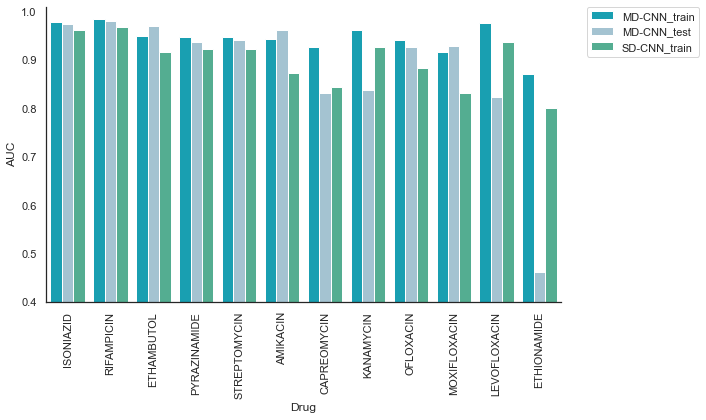

In [31]:
# Barplot of the AUC for each
colors=[
        "#00b3ca","#9dc6d8","#45bc96","#7dd0b6"
]
sns.set(rc={"lines.linewidth": 1})
sns.set_style("white")
sns.set_palette(sns.color_palette(colors))

figure = plt.figure(figsize=(10,6))
ax = figure.gca()

# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(drug_list, range(len(drug_list))))
model_order = ["MD-CNN_train", "MD-CNN_test", "SD-CNN_train", "SD-CNN_test"]
modelSorterIndex = dict(zip(model_order, range(len(model_order))))

# Generate a rank column that will be used to sort
# the dataframe numerically
d['rank'] = d['Drug'].map(sorterIndex)
d['model_rank'] =d["set"].map(modelSorterIndex)
d = d.sort_values(["rank", "model_rank"])


sns.barplot(data=d, x="Drug", y="AUC", hue="set", ci=None)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylim([0.4,1.01])
sns.despine()
plt.xticks(rotation = 90)

plt.tight_layout()
plt.savefig("CNN_generalization.pdf")
plt.show()

In [33]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_train = d.query("set=='MD-CNN_train' and Drug in @first_line")
print("Mean first line MD-CNN AUC, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='MD-CNN_test' and Drug in @first_line")
print("Mean first line MD-CNN AUC, test", first_line_test.AUC.mean())

first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_train = d.query("set=='SD-CNN_train' and Drug in @first_line")
print("Mean first line SD-CNN AUC, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='SD-CNN_test' and Drug in @first_line")
print("Mean first line SD-CNN AUC, test", first_line_test.AUC.mean())


Mean first line MD-CNN AUC, train 0.9648425458975708
Mean first line MD-CNN AUC, test 0.9652885824613107
Mean first line SD-CNN AUC, train 0.9381425692353895
Mean first line SD-CNN AUC, test nan


In [34]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_train = d.query("set=='MD-CNN_train' and not Drug in @first_line")
print("Mean second line MD-CNN AUC, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='MD-CNN_test' and not Drug in @first_line")
print("Mean second line MD-CNN AUC, test", first_line_test.AUC.mean())

first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
first_line_train = d.query("set=='SD-CNN_train' and not Drug in @first_line")
print("Mean second line SD-CNN AUC, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='SD-CNN_test' and not Drug in @first_line")
print("Mean second line SD-CNN AUC, test", first_line_test.AUC.mean())


Mean second line MD-CNN AUC, train 0.9353364586799685
Mean second line MD-CNN AUC, test 0.8388405077792582
Mean second line SD-CNN AUC, train 0.8774943631464815
Mean second line SD-CNN AUC, test nan


In [35]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
second_line_bad = ["CAPREOMYCIN", "KANAMYCIN", "LEVOFLOXACIN", "ETHIONAMIDE"]

first_line_train = d.query("set=='MD-CNN_train' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line MD-CNN AUC, bad generalizers, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='MD-CNN_test' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line MD-CNN AUC, bad generalizers, test", first_line_test.AUC.mean())


Mean 2nd line AUC, train 0.9336686769329151
Mean 2nd line  AUC, test 0.7383012120075273


In [36]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
second_line_bad = ["CAPREOMYCIN", "KANAMYCIN", "LEVOFLOXACIN", "ETHIONAMIDE"]

first_line_train = d.query("set=='MD-CNN_train' and not Drug in @first_line and not Drug in @second_line_bad")
print("Mean 2nd line MD-CNN AUC, good generalizers, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='MD-CNN_test' and not Drug in @first_line and not Drug in @second_line_bad")
print("Mean 2nd line MD-CNN AUC, good generalizers, test", first_line_test.AUC.mean())


Mean 2nd line AUC, train 0.937004240427022
Mean 2nd line  AUC, test 0.9393798035509893


In [37]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
second_line_bad = ["CAPREOMYCIN", "KANAMYCIN", "LEVOFLOXACIN", "ETHIONAMIDE"]

first_line_train = d.query("set=='SD-CNN_train' and not Drug in @first_line and not Drug in @second_line_bad")
print("Mean 2nd line SD-CNN AUC, good generalizers, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='SD-CNN_test' and not Drug in @first_line and not Drug in @second_line_bad")
print("Mean 2nd line SD-CNN AUC, good generalizers, test", first_line_test.AUC.mean())


Mean 2nd line AUC, train 0.877647632097198
Mean 2nd line  AUC, test nan


In [38]:
first_line = ["ISONIAZID", "RIFAMPICIN", "ETHAMBUTOL", "PYRAZINAMIDE"]
second_line_bad = ["CAPREOMYCIN", "KANAMYCIN", "LEVOFLOXACIN", "ETHIONAMIDE"]

first_line_train = d.query("set=='SD-CNN_train' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line SD-CNN AUC, bad generalizers, train", first_line_train.AUC.mean())

first_line_test = d.query("set=='SD-CNN_test' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line SD-CNN AUC, bad generalizers, test", first_line_test.AUC.mean())


Mean 2nd line AUC, train 0.8773410941957653
Mean 2nd line  AUC, test nan


In [ ]:
first_line_train = d.query("set=='Reg+L2' and not Drug in @first_line and Drug in @second_line_bad")
print("Mean 2nd line AUC, train", first_line_train.AUC.mean())